In [1]:
import numpy as np
import extq
import ivac
import pyemma
import glob
import sys
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
sys.path.insert(1, "../python")
sys.path.insert(1, "../../")
import util
import kde

In [3]:
import seaborn as sns

plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load feature 2 data (salt bridges)

In [4]:
with np.load("../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
print(len(data))
print(data[0].shape)

1295
(3000, 60)


In [6]:
data_arr = np.concatenate(data)
print(data_arr.shape)

(6580000, 60)


## load CVs 

In [7]:
with np.load("../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [8]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)
cv_trajs = np.split(cv_arr, traj_inds)

In [9]:
cv_arr.shape

(6580000, 2)

In [10]:
# take only last 30 features (Cz - Cd distances)
data_cz = [traj[:, 30:] for traj in data]

## Models 

In [11]:
feat2_models = np.load("../data/models_feat2.npy")

In [12]:
models_cz = feat2_models[:, 30:]

# two-radial basis 

In [13]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "D186", "E183"):
        sb_labels.append(f"{r} - {n}")

In [14]:
sb_labels

['R217 - D129',
 'R217 - D136',
 'R217 - D151',
 'R217 - D164',
 'R217 - D186',
 'R217 - E183',
 'R223 - D129',
 'R223 - D136',
 'R223 - D151',
 'R223 - D164',
 'R223 - D186',
 'R223 - E183',
 'R226 - D129',
 'R226 - D136',
 'R226 - D151',
 'R226 - D164',
 'R226 - D186',
 'R226 - E183',
 'R229 - D129',
 'R229 - D136',
 'R229 - D151',
 'R229 - D164',
 'R229 - D186',
 'R229 - E183',
 'R232 - D129',
 'R232 - D136',
 'R232 - D151',
 'R232 - D164',
 'R232 - D186',
 'R232 - E183']

In [15]:
# useful salt bridges
# R223-D129, R226-D129, R229-D129, R226-D186, R229-D186, R232-D186
sb_ids = [36, 42, 48, 46, 52, 58]

In [16]:
data_sb = [traj[:, sb_ids] for traj in data]

In [17]:
data_sb_arr = np.concatenate(data_sb)
data_sb_arr.shape

(6580000, 6)

In [18]:
# define radial basis functions
def gauss_short(r, r0, d0):
    return np.where(r < d0, 1, np.exp(-((r - d0) ** 2) / (2 * r0 ** 2)))


def gauss_long(r, r0, d0):
    return 1 - gauss_short(r, r0, d0)

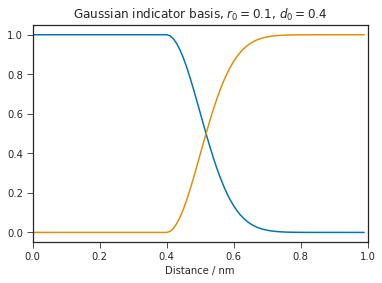

In [19]:
x = np.arange(0, 1, 0.01)
plt.plot(x, gauss_short(x, 0.1, 0.4))
plt.plot(x, gauss_long(x, 0.1, 0.4))
plt.xlabel("Distance / nm")
plt.title("Gaussian indicator basis, $r_0 = 0.1$, $d_0 = 0.4$")
plt.xlim([0, 1])
plt.savefig("../fig/gaussian-ind-basis-r1d4", dpi=200)

## IVAC

In [20]:
km100 = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=data_sb_arr, k=100, max_iter=100, n_jobs=16
)

03-05-21 19:26:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Cluster centers converged after 29 steps.


In [21]:
data_km100_arr = km100.dtrajs

In [22]:
data_km100_arr = data_km100_arr[0]

In [23]:
# indicator basis
data_ind_basis_100 = np.zeros((len(data_sb_arr), 100))
for i in range(100):
    data_ind_basis_100[data_km100_arr == i, i] = 1

In [24]:
data_ind_basis_100.shape

(6580000, 100)

In [25]:
# IVAC
data_ind100_trajs = np.split(data_ind_basis_100, traj_inds)
livac_km100 = ivac.LinearIVAC(
    minlag=1,
    maxlag=3000,
    nevecs=5,
    addones=False,
    reweight=False,
    adjust=True,
    method="fft",
)
livac_km100.fit(data_ind100_trajs)

In [27]:
livac_km100_trajs = livac_km100.transform(data_ind100_trajs)
livac_km100_arr = np.concatenate(livac_km100_trajs)
models_sb = feat2_models[:, sb_ids]
models_km100_arr = km100.assign(models_sb)
models_ind100_basis = np.zeros((4, 100))
for i in range(100):
    models_ind100_basis[models_km100_arr == i, i] = 1
models_km100 = livac_km100.transform([models_ind100_basis])[0]

In [28]:
km100.save("../data/sb_ind100_TICA/km100")
np.save("../data/sb_ind100_TICA/livac_trajs.npy", livac_km100_trajs)
np.save("../data/sb_ind100_TICA/models.npy", models_km100)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:46: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(name) as h5f:
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or

### load indicator featurized trajectories 

In [4]:
livac_km100_trajs = np.load("../data/sb_ind100_TICA/livac_trajs.npy", allow_pickle=True)
models_km100 = np.load("../data/sb_ind100_TICA/models.npy", allow_pickle=True)

In [5]:
livac_km100_arr = np.concatenate(livac_km100_trajs)

In [6]:
livac_km100_arr.shape

(6580000, 5)

# Look at states in this IVAC space 

In [15]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]

# ellipse centered at (-8.919, -109.9) with radii 0.632 and 9.8 (1 sigma in each direction) for down- state
# take points where TIC 1 < -1
dist_ax_down = (dist + 8.919) / 0.632
rot_ax_down = (rot + 109.9) / 9.8
downmin_ids = (((dist_ax_down ** 2 + rot_ax_down ** 2) < 1)).nonzero()[0]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 > 1.1
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1)).nonzero()[0]

In [16]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[downmin_ids] = False
mask[upplus_ids] = False

# len(**_ids) is number of points in each state
downmin = data_arr[downmin_ids]
upplus = data_arr[upplus_ids]
other = data_arr[mask]

# split CV data
downmin_cvs = cv_arr[downmin_ids]
upplus_cvs = cv_arr[upplus_ids]
other_cvs = cv_arr[mask]

In [17]:
assert (len(downmin) + len(upplus) + len(other)) == len(cv_arr)
print(f"Number of down- structures:  {len(downmin)}")
print(f"Number of up+ structures:   {len(upplus)}")
print(f"Number of other structures: {len(other)}")

Number of down- structures:  1536
Number of up+ structures:   54524
Number of other structures: 6523940


In [18]:
downmin_livac = livac_km100_arr[downmin_ids]
upplus_livac = livac_km100_arr[upplus_ids]
other_livac = livac_km100_arr[mask]

NameError: name 'livac_km100_arr' is not defined

In [ ]:
plt.hist(downmin_livac[:, 1], bins=20)
plt.twinx()
plt.hist(upplus_livac[:, 1], bins=20)

## 4 states 

In [48]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]

# centers of states based off initial crystal structure/homology models
# ellipse centered at (-8.919, -109.9) with radii 0.632 and 9.8 for down - state
downmin_ids = (
    (((dist + 8.919) / 0.632) ** 2 + ((rot + 109.9) / 9.8) ** 2) < 1
).nonzero()[0]

# ellipse centered at (-4.174 , -50.8) with radii 0.574 and 8.21 (1 sigma in each direction) for down state
down_ids = ((((dist + 4.174) / 0.574) ** 2 + ((rot + 50.8) / 8.21) ** 2) < 1).nonzero()[
    0
]

# ellipse centered at (0, 0) with radii 0.460 and 2.9 for up state
up_ids = (((dist / 0.460) ** 2 + (rot / 2.9) ** 2) < 1).nonzero()[0]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
upplus_ids = (
    (((dist - 4.535) / 0.632) ** 2 + ((rot - 43.7) / 4.0) ** 2) < 1
).nonzero()[0]

In [49]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[downmin_ids] = False
mask[down_ids] = False
mask[up_ids] = False
mask[upplus_ids] = False

# len(**_ids) is number of points in each state
downmin = data_arr[downmin_ids]
down = data_arr[down_ids]
up = data_arr[up_ids]
upplus = data_arr[upplus_ids]
other = data_arr[mask]

# split CV data
downmin_cvs = cv_arr[downmin_ids]
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
upplus_cvs = cv_arr[upplus_ids]
other_cvs = cv_arr[mask]

## IVAC split 

In [50]:
downmin_livac = livac_km100_arr[downmin_ids]
down_livac = livac_km100_arr[down_ids]
up_livac = livac_km100_arr[up_ids]
upplus_livac = livac_km100_arr[upplus_ids]

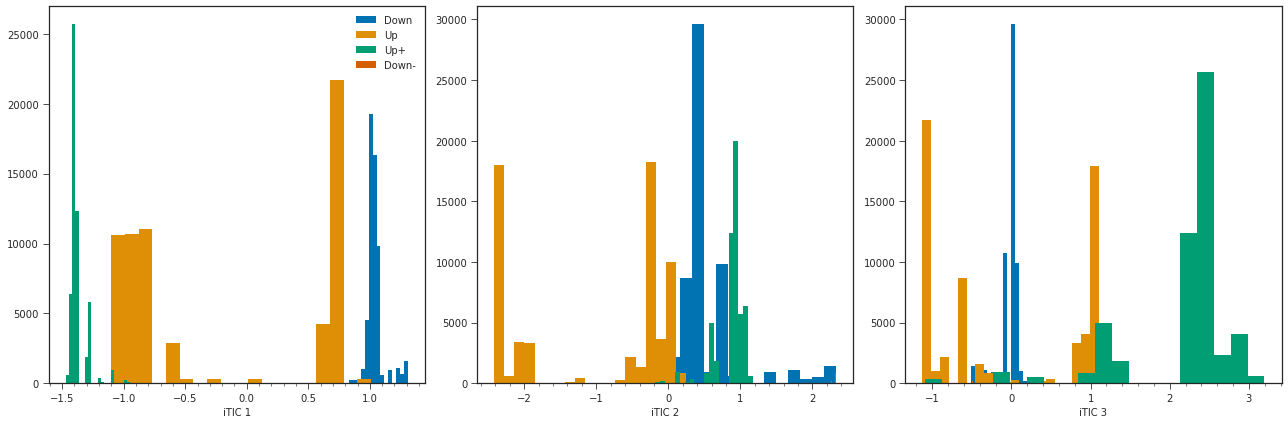

In [51]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    for state in (down_livac, up_livac, upplus_livac, downmin_livac):
        ax.hist(state[:, i + 1], bins=20)
    ax.set_xlabel(f"iTIC {i + 1}")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

axs[0].legend(["Down", "Up", "Up+", "Down-"])
f.tight_layout()

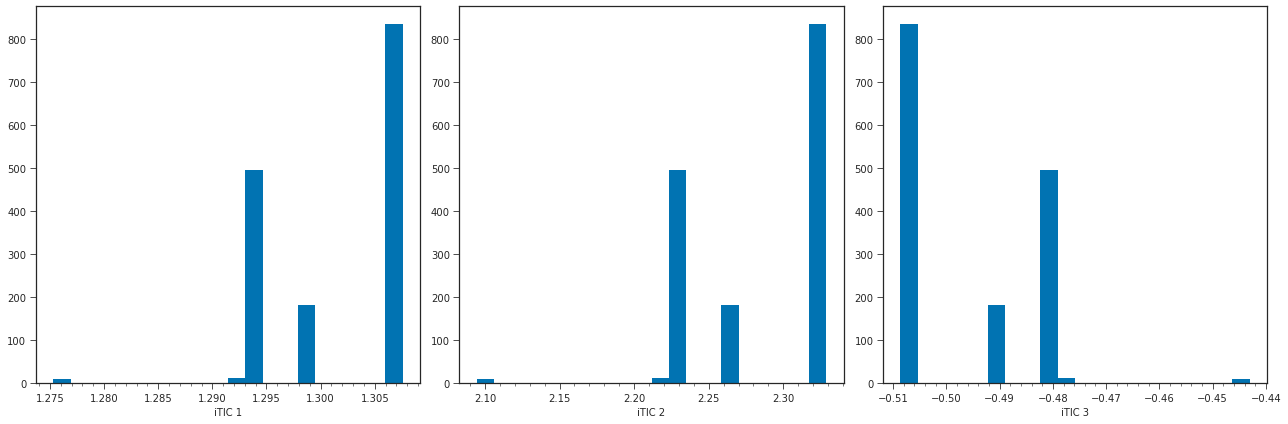

In [95]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    ax.hist(downmin_livac[:, i + 1], bins=20)
    ax.set_xlabel(f"iTIC {i + 1}")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

f.tight_layout()

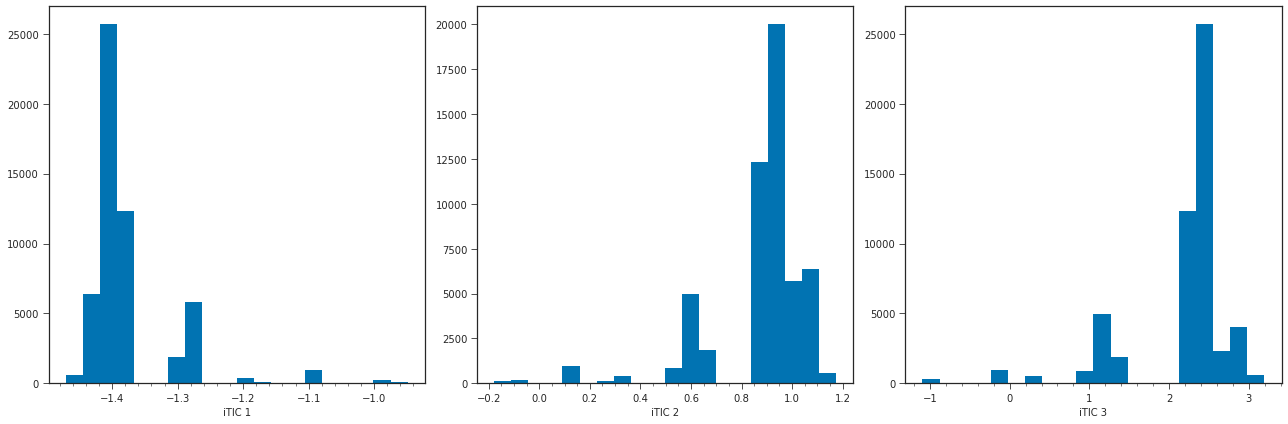

In [107]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    ax.hist(upplus_livac[:, i + 1], bins=20)
    ax.set_xlabel(f"iTIC {i + 1}")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

f.tight_layout()

In [36]:
from itertools import combinations

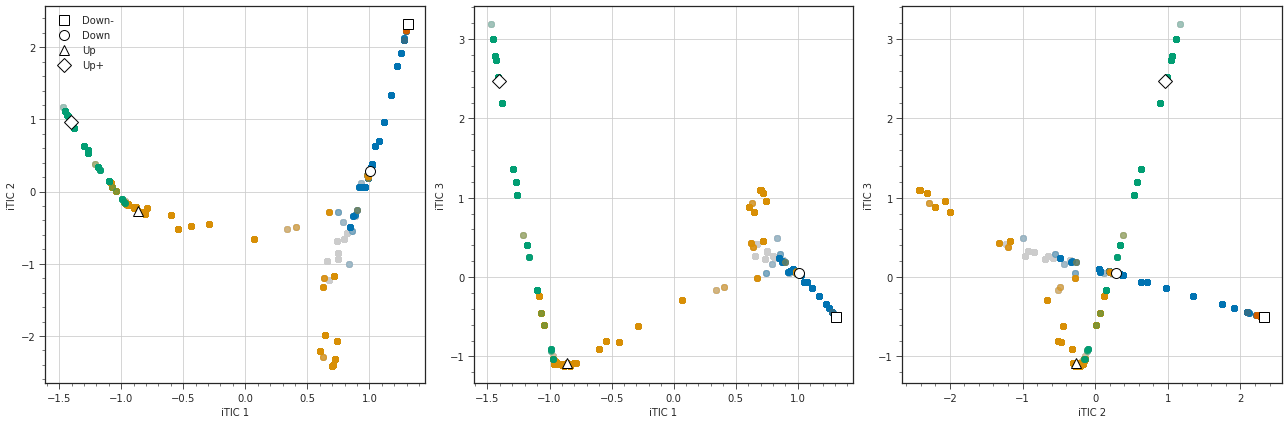

In [52]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for (i, j), ax in zip(combinations(range(1, 4), 2), axs):
    ax.scatter(livac_km100_arr[::20, i], livac_km100_arr[::20, j], c="0.8", alpha=0.2)
    for state in (down_livac, up_livac, upplus_livac, downmin_livac):
        ax.scatter(state[::10, i], state[::10, j], alpha=0.2)

    ax.set_xlabel(f"iTIC {i}")
    ax.set_ylabel(f"iTIC {j}")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.grid()

util.plot_models(axs[0], models_km100[:, 1:3])
util.plot_models(axs[1], models_km100[:, 1:4:2])
util.plot_models(axs[2], models_km100[:, 2:4])
axs[0].legend(["Down-", "Down", "Up", "Up+"])

f.tight_layout()

## Do the various peaks correspond to the  same as the other iTIC peaks?

In [53]:
# up state points iTIC1 > 0.5?
idx1 = up_livac[:, 1].argsort()
print(up_ids[idx1[-10:]])

# up state points iTIC2 < -2?
idx2 = up_livac[:, 2].argsort()
print(up_ids[idx2[:10]])

# up state with iTIC1 at low values (< -1.2)
print(up_ids[idx1[:10]])

# Down- state with iTIC1 at high values
idx3 = downmin_livac[:, 1].argsort()
print(downmin_ids[idx3[-10:]])

# up+ state with higher iTIC1 values
idx4 = upplus_livac[:, 1].argsort()
print(upplus_ids[idx4[-10:]])

# up+ states near iTIC1 ~ -1.3
idx5 = ((upplus_livac[:, 1] + 1.3) ** 2).argsort()
print(upplus_ids[idx5[:10]])

[4861341 4045019 4045104 4045125 4045896 4855568 4854289 4885686 4045278
 4045826]
[5741655 6283346 6283353 6283375 6283379 6283380 6283382 5741565 5741564
 6410683]
[3836666 3837216 3836673 3836587 3826340 3834233 3834243 3837154 3836633
 3837155]
[1190636 1190635 1190634 1190633 1190631 1190627 1190625 1190623 1190639
 4620040]
[3394615 3394617 3394607 3959196 3396645 3958962 3957276 3957109 3957214
 3396108]
[ 554823 3870128 3870124 3870044 3870009 3870007 3870006 3846061 3846059
 3846058]


### expanded states (S1 helix)? (seen from radial basis in `ivac-2.ipynb`)

In [54]:
print(sorted(up_livac[:, 2])[:20])

[-2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066, -2.4186857397649066]


In [56]:
livac_km100_arr[5741655, 2]

-2.4186857397649066

In [61]:
# points near with iTIC2 ~ -2
idx6 = ((livac_km100_arr[:, 2] + 2) ** 2).argsort()
print(idx6[:10])

[6410369 6190333 6190332 6190331 6190330 6190329 6190328 6190327 6190326
 6190325]


#### points near iTIC2 ~ 2

trajectory 278: frames around 300 also show the same expansion of S1 helix

In [62]:
util.frame(6410369)

(1278, 369)

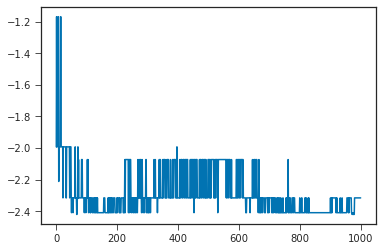

In [64]:
plt.plot(livac_km100_trajs[1278][::10, 2])

(-50.0, 50.0)

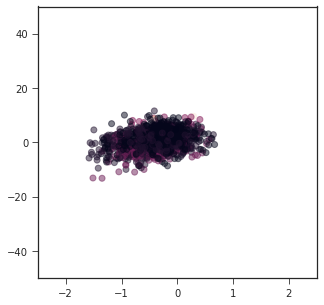

In [79]:
f, ax = plt.subplots(figsize=(5, 5))
plt.scatter(
    *cv_trajs[1278][::10].T,
    c=livac_km100_trajs[1278][::10, 2],
    cmap="rocket",
    alpha=0.5
)
plt.xlim([-2.5, 2.5])
plt.ylim(-50, 50)

In [145]:
for idx in idx6[:10]:
    print(util.frame(idx))

(1278, 369)
(1256, 333)
(1256, 332)
(1256, 331)
(1256, 330)
(1256, 329)
(1256, 328)
(1256, 327)
(1256, 326)
(1256, 325)


#### Points near iTIC2 ~ -1.5

In [68]:
# points near with iTIC2 ~ -1.5
idx7 = ((livac_km100_arr[:, 2] + 1.5) ** 2).argsort()
print(idx7[:20])

[5179223 6495797 6495796 6495795 6495794 6495793 6495792 6495791 6495790
 6495789 6495788 6495787 6495786 6495785 6495784 6495783 6495782 6495780
 6495765 6495766]


In [67]:
util.frame(6495797)

(1286, 5797)

Trajectory 1182:

Trajectory 1286/5750 - 5800: moderately expanded? it's hard to tell

(-50.0, 50.0)

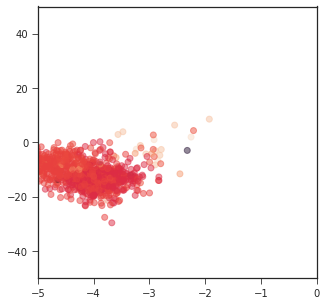

In [81]:
f, ax = plt.subplots(figsize=(5, 5))
plt.scatter(
    *cv_trajs[1286][::10].T,
    c=livac_km100_trajs[1286][::10, 2],
    cmap="rocket",
    alpha=0.5
)
plt.xlim([-5, 0])
plt.ylim(-50, 50)

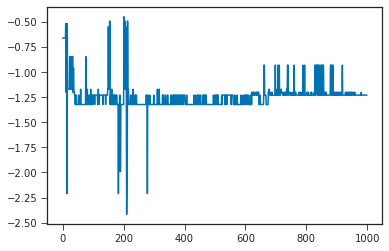

In [83]:
plt.plot(livac_km100_trajs[1286][::10, 2])

#### Check points where iTIC2 < -2 (very bottom)

In [59]:
util.frame(6410683)

(1278, 683)

Comes from 2 trajectories, 1211 and 1265 (last one from 1278)
tend to show S1 helix lifted "up and away", I126 is flexed away

(-50.0, 50.0)

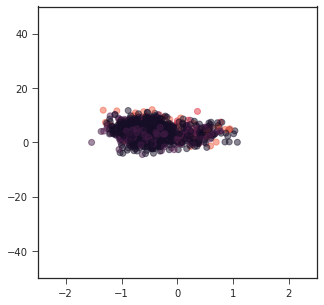

In [82]:
f, ax = plt.subplots(figsize=(5, 5))
plt.scatter(
    *cv_trajs[1211][::10].T,
    c=livac_km100_trajs[1211][::10, 2],
    cmap="rocket",
    alpha=0.5
)
plt.xlim([-2.5, 2.5])
plt.ylim(-50, 50)

#### Do these correspond with the same point in iTIC3 clustered in up state?

In [86]:
print(up_ids[up_livac[:, 3].argsort()][-10:])

[6258998 5788358 5788965 6259009 6259020 6259053 6259260 6259306 6259398
 6137911]


Trajectories 1262, 1215: S1 is even further up than the ones looked at before

In [87]:
livac_km100_arr[6258998, 3]

1.101479603170542

In [91]:
for idx in up_ids[up_livac[:, 3].argsort()][-10:]:
    print(util.frame(idx))

(1262, 8998)
(1215, 8358)
(1215, 8965)
(1262, 9009)
(1262, 9020)
(1262, 9053)
(1262, 9260)
(1262, 9306)
(1262, 9398)
(1250, 7911)


Text(0, 0.5, 'iTIC 3')

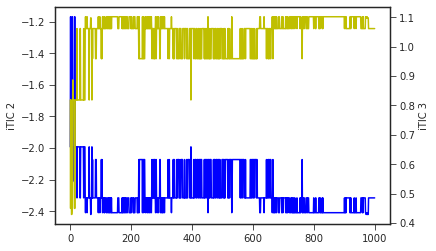

In [100]:
plt.plot(livac_km100_trajs[1262][::10, 2], "b")
plt.ylabel("iTIC 2")
plt.twinx()
plt.plot(livac_km100_trajs[1262][::10, 3], "y")
plt.ylabel("iTIC 3")

(-50.0, 50.0)

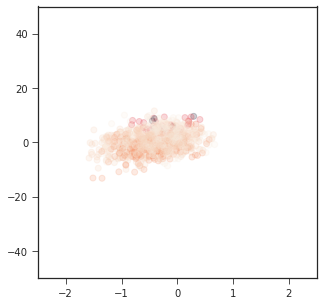

In [94]:
f, ax = plt.subplots(figsize=(5, 5))
plt.scatter(
    *cv_trajs[1262][::10].T,
    c=livac_km100_trajs[1262][::10, 3],
    cmap="rocket",
    alpha=0.2
)
plt.xlim([-2.5, 2.5])
plt.ylim(-50, 50)

#### What about other end of up state iTIC2?

In [104]:
for idx in up_ids[idx2[-10:]]:
    print(f"{util.frame(idx)} : {livac_km100_arr[idx, 2]:.3f}")

(1082, 6187) : 0.294
(1082, 6191) : 0.294
(1082, 6192) : 0.294
(1082, 6340) : 0.337
(1083, 4243) : 0.337
(1083, 4233) : 0.337
(1083, 6673) : 0.387
(1083, 7216) : 0.387
(1083, 6666) : 0.387
(1083, 6587) : 0.387


### others 

In [117]:
livac_km100_arr[750615, 1]

-1.2964108098095293

In [123]:
util.frame(750623)

(250, 623)

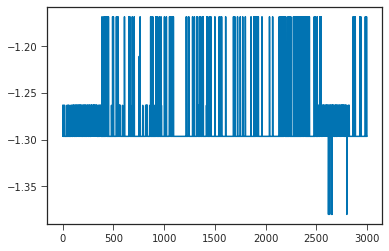

In [124]:
plt.plot(livac_km100_trajs[250][:, 1])

(-25.0, 25.0)

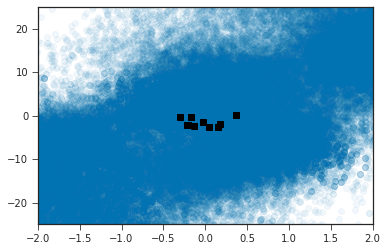

In [101]:
plt.scatter(cv_arr[::20, 0], cv_arr[::20, 1], alpha=0.05)
plt.plot(cv_arr[up_ids[idx1[-10:]], 0], cv_arr[up_ids[idx1[-10:]], 1], "ks")
plt.xlim([-2, 2])
plt.ylim([-25, 25])

(25.0, 75.0)

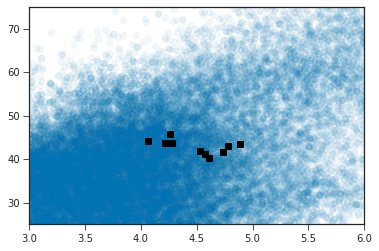

In [119]:
plt.scatter(cv_arr[::20, 0], cv_arr[::20, 1], alpha=0.05)
plt.plot(cv_arr[upplus_ids[idx5[:10]], 0], cv_arr[upplus_ids[idx5[:10]], 1], "ks")
plt.xlim([3, 6])
plt.ylim([25, 75])

In [106]:
for idx in upplus_ids[idx4[-10:]]:
    print(f"{util.frame(idx)} : {livac_km100_arr[idx, 1]:.3f}")

(1039, 4615) : -0.968
(1039, 4617) : -0.968
(1039, 4607) : -0.968
(1095, 9196) : -0.958
(1039, 6645) : -0.958
(1095, 8962) : -0.958
(1095, 7276) : -0.956
(1095, 7109) : -0.956
(1095, 7214) : -0.956
(1039, 6108) : -0.949


In [105]:
for idx in upplus_ids[idx5[:10]]:
    print(f"{util.frame(idx)} : {livac_km100_arr[idx, 1]:.3f}")

(184, 2823) : -1.296
(1087, 128) : -1.296
(1087, 124) : -1.296
(1087, 44) : -1.296
(1087, 9) : -1.296
(1087, 7) : -1.296
(1087, 6) : -1.296
(1084, 6061) : -1.296
(1084, 6059) : -1.296
(1084, 6058) : -1.296


In [109]:
idx8 = ((upplus_livac[:, 1] + 1.1) ** 2).argsort()
for idx in upplus_ids[idx8[:10]]:
    print(f"{util.frame(idx)} : {livac_km100_arr[idx, 1]:.3f}")

(1290, 3249) : -1.098
(1095, 6974) : -1.098
(1095, 6976) : -1.098
(1095, 6977) : -1.098
(1095, 6978) : -1.098
(1095, 6979) : -1.098
(1095, 6980) : -1.098
(1095, 6981) : -1.098
(1095, 6983) : -1.098
(1095, 6984) : -1.098


In [110]:
idx8 = ((upplus_livac[:, 1] + 1.2) ** 2).argsort()
for idx in upplus_ids[idx8[:10]]:
    print(f"{util.frame(idx)} : {livac_km100_arr[idx, 1]:.3f}")

(965, 713) : -1.211
(1045, 5466) : -1.211
(1185, 89366) : -1.211
(1185, 52666) : -1.211
(1045, 5467) : -1.211
(1185, 42209) : -1.211
(1185, 63150) : -1.184
(483, 2705) : -1.184
(483, 2704) : -1.184
(483, 2703) : -1.184


#### *Something crazy is going on with the Anton trajectory 1185*

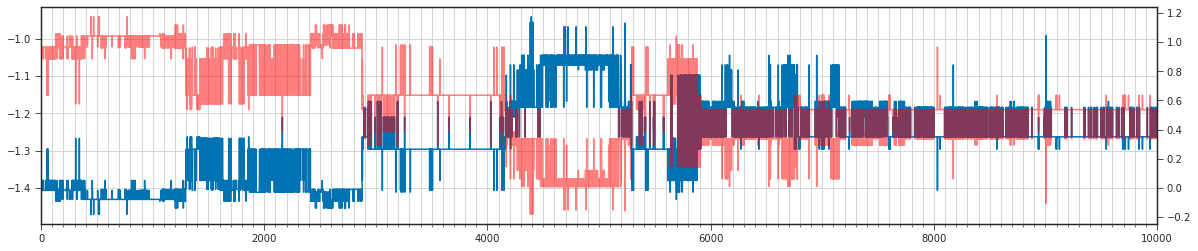

In [127]:
f, ax = plt.subplots(figsize=(20, 4))
plt.plot(livac_km100_trajs[1185][::10, 1])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=20))
ax.set_xlim([0, 10000])
ax.grid(which="both")
plt.twinx()
plt.plot(livac_km100_trajs[1185][::10, 2], "r", alpha=0.5)

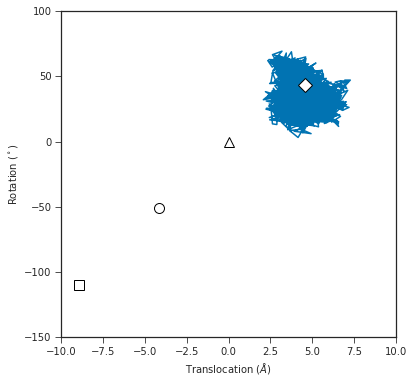

In [116]:
f, ax = plt.subplots(figsize=(6, 6))
ax.plot(cv_trajs[1185][::10, 0], cv_trajs[1185][::10, 1])
util.format_cvs(ax)

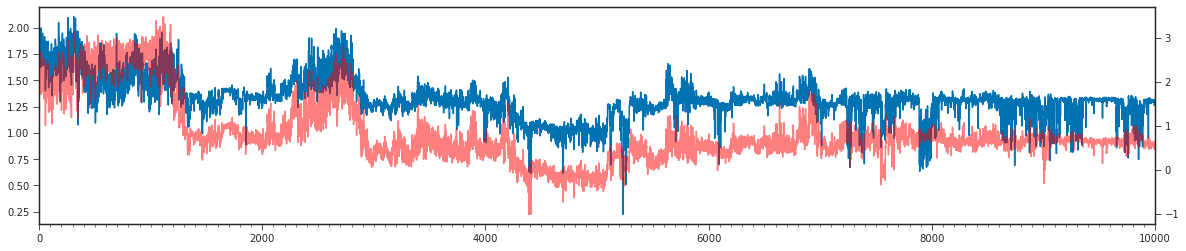

In [125]:
f, ax = plt.subplots(figsize=(20, 4))
plt.plot(livac_trajs[1185][::10, 1])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=20))
ax.set_xlim([0, 10000])
plt.twinx()
plt.plot(livac_trajs[1185][::10, 2], "r", alpha=0.5)

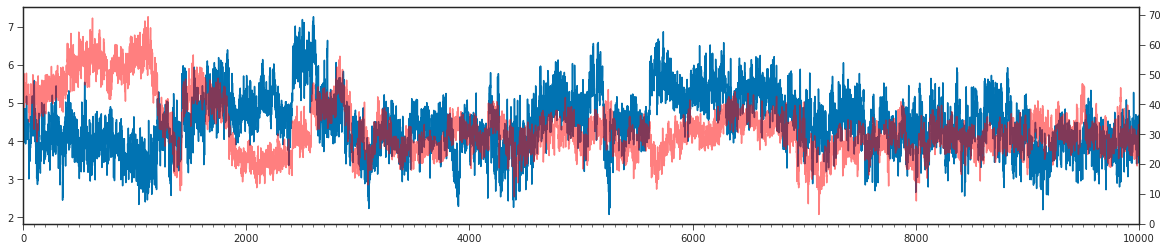

In [128]:
f, ax = plt.subplots(figsize=(20, 4))
plt.plot(cv_trajs[1185][::10, 0])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=20))
ax.set_xlim([0, 10000])
plt.twinx()
plt.plot(cv_trajs[1185][::10, 1], "r", alpha=0.5)

#### Compute distances from arginines to Ile126 for trajectory 1185

In [136]:
featurizer = pyemma.coordinates.featurizer("../civsd-pro.pdb")
R_cz = featurizer.select("residue 217 223 226 229 232 and name CZ")
I_cb = featurizer.select("residue 126 and name CB")
featurizer.add_distances(R_cz, indices2=I_cb)

06-05-21 19:33:13 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[3] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


In [137]:
featurizer.describe()

['DIST: ARG 217 CZ 1781 - ILE 126 CB 350',
 'DIST: ARG 223 CZ 1885 - ILE 126 CB 350',
 'DIST: ARG 226 CZ 1947 - ILE 126 CB 350',
 'DIST: ARG 229 CZ 2003 - ILE 126 CB 350',
 'DIST: ARG 232 CZ 2056 - ILE 126 CB 350']

In [138]:
ri_raw = pyemma.coordinates.load(
    ["../anton/xtc1000ns/civsd-185.xtc"], features=featurizer, chunksize=32
)

In [139]:
ri_raw.shape

(100000, 5)

(0.0, 10000.0)

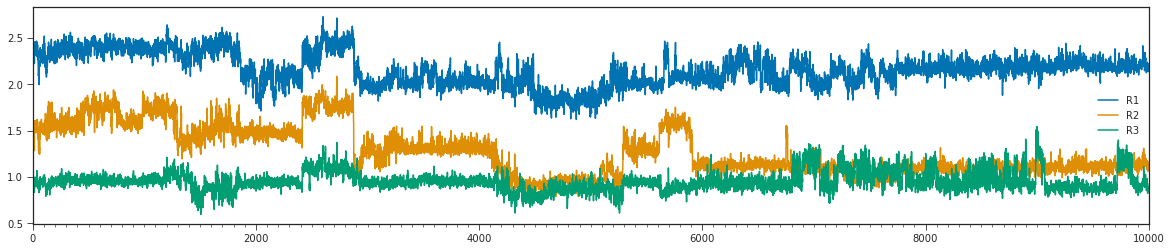

In [144]:
f, ax = plt.subplots(figsize=(20, 4))

plt.plot(ri_raw[::10, 1])
plt.plot(ri_raw[::10, 2])
plt.plot(ri_raw[::10, 3])
ax.legend(["R1", "R2", "R3"])

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=20))
ax.set_xlim([0, 10000])

# How do these iTICs compare with previous ones?

In [124]:
livac_trajs = np.load("../data/sb-livac-gauss.npy", allow_pickle=True)
print(livac_trajs.shape)
livac_arr = np.concatenate(livac_trajs)
print(livac_arr.shape)
models_livac = np.load("../data/models-livac-gauss.npy")

(1295,)
(6580000, 5)


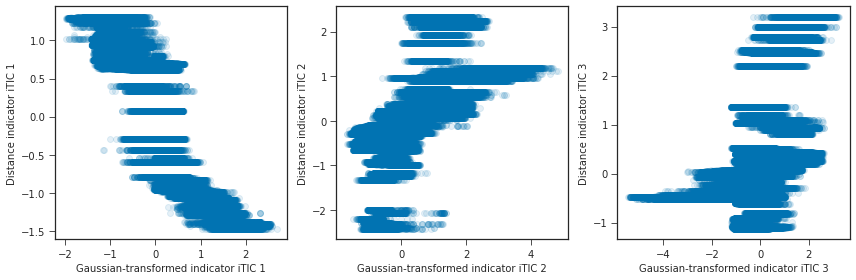

In [49]:
f, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axs):
    ax.scatter(livac_arr[::10, i + 1], livac_km100_arr[::10, i + 1], alpha=0.1)
    ax.set_xlabel(f"Gaussian-transformed indicator iTIC {i+1}")
    ax.set_ylabel(f"Distance indicator iTIC {i+1}")
f.tight_layout()

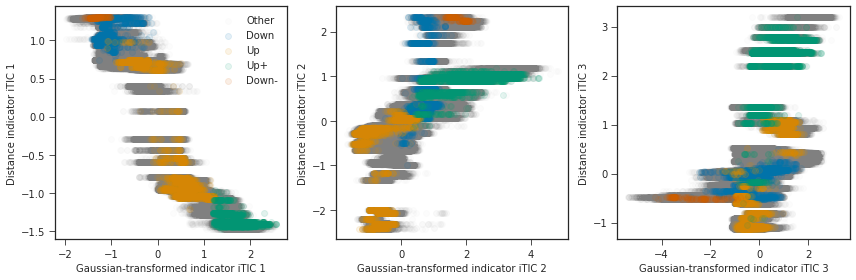

In [69]:
f, axs = plt.subplots(1, 3, figsize=(12, 4))
downmin_gauss = livac_arr[downmin_ids]
down_gauss = livac_arr[down_ids]
up_gauss = livac_arr[up_ids]
upplus_gauss = livac_arr[upplus_ids]
for i, ax in enumerate(axs):
    ax.scatter(
        livac_arr[::20, i + 1], livac_km100_arr[::20, i + 1], alpha=0.02, color="grey"
    )
    for arr1, arr2 in zip(
        (down_livac, up_livac, upplus_livac, downmin_livac),
        (down_gauss, up_gauss, upplus_gauss, downmin_gauss),
    ):
        ax.scatter(arr2[::10, i + 1], arr1[::10, i + 1], alpha=0.1)
    ax.set_xlabel(f"Gaussian-transformed indicator iTIC {i+1}")
    ax.set_ylabel(f"Distance indicator iTIC {i+1}")
axs[0].legend(["Other", "Down", "Up", "Up+", "Down-"])
f.tight_layout()

# What about states with iTIC cutoffs 

In [50]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]

# ellipse centered at (-8.919, -109.9) with radii 0.632 and 9.8 (1 sigma in each direction) for down- state
# take points where TIC 1 < -1
dist_ax_down = (dist + 8.919) / 0.632
rot_ax_down = (rot + 109.9) / 9.8
downmin_ids = (((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (tic1 < -1.0)).nonzero()[
    0
]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 > 1.1
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 > 1.2)).nonzero()[0]

In [51]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[downmin_ids] = False
mask[upplus_ids] = False

# len(**_ids) is number of points in each state
downmin = data_arr[downmin_ids]
upplus = data_arr[upplus_ids]
other = data_arr[mask]

# split CV data
downmin_cvs = cv_arr[downmin_ids]
upplus_cvs = cv_arr[upplus_ids]
other_cvs = cv_arr[mask]

In [52]:
downmin_livac = livac_km100_arr[downmin_ids]
upplus_livac = livac_km100_arr[upplus_ids]
other_livac = livac_km100_arr[mask]

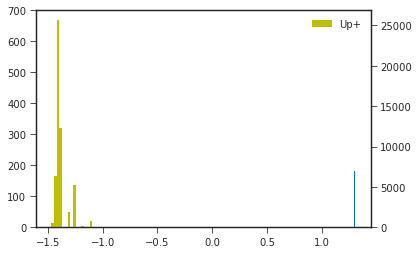

In [53]:
plt.hist(downmin_livac[:, 1], bins=20, label="Down-")
plt.twinx()
plt.hist(upplus_livac[:, 1], bins=20, color="y", label="Up+")
plt.legend()

# Count number of outlier states 

5.11.21

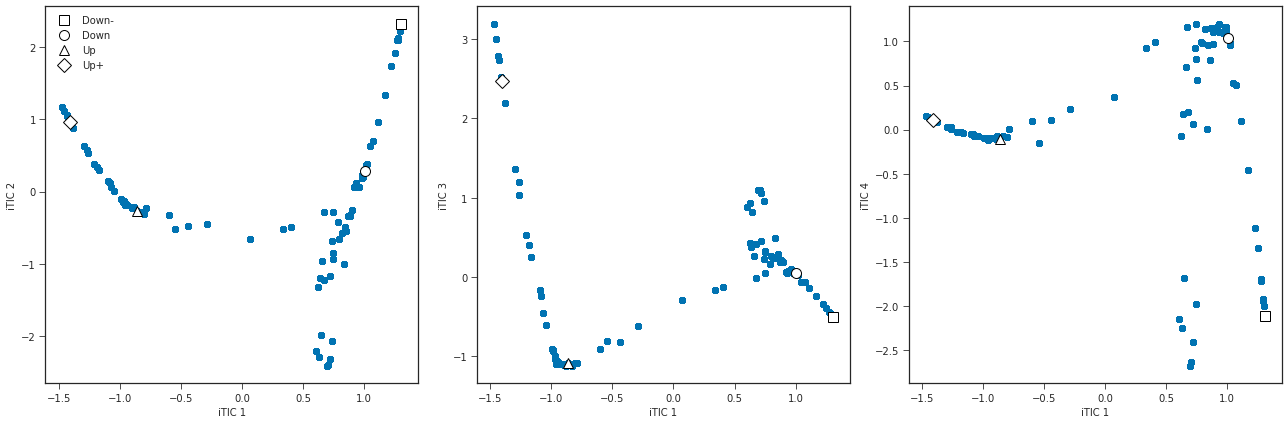

In [7]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(livac_km100_arr[::10, 1], livac_km100_arr[::10, i + 2], alpha=0.1)
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_km100[:, 1:3])
util.plot_models(axs[1], models_km100[:, 1:4:2])
util.plot_models(axs[2], models_km100[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
# plt.savefig('../fig/ivac-ind100-dataproj.png', dpi=300)

In [12]:
# cutoff for iTIC2 < -1.5
print(np.count_nonzero(livac_km100_arr[:, 2] < -1.5))

344305


In [14]:
344305 / len(livac_km100_arr) * 100

5.232598784194529

In [16]:
# cutoff for iTIC2 < -1.2
print(np.count_nonzero(livac_km100_arr[:, 2] < -1.2) / len(livac_km100_arr) * 100)

8.277674772036473


In [24]:
# cutoff for iTIC 3 > 0.6 and 0.5 < iTIC1 < 1.0
itic1 = livac_km100_arr[:, 1]
itic3 = livac_km100_arr[:, 3]
print(np.count_nonzero((itic1 > 0.5) & (itic1 < 1.0) & (itic3 > 0.6)))

344305


In [25]:
# cutoff for iTIC2 < -0.9
print(np.count_nonzero(livac_km100_arr[:, 2] < -0.9) / len(livac_km100_arr) * 100)

12.300699088145898
